In [16]:
import numpy as np
import pandas as pd
import os
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# Load the Data and set up train and test

In [17]:
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'
train_file = data_path + data_prefix + 'classifier_train_data.xlsx'
test_file = data_path + data_prefix + 'classifier_test_data.xlsx'

train = pd.read_excel(train_file, index_col=0)
test = pd.read_excel(test_file, index_col=0)

display(train.head(3))
display(test.head(3))

,roc_4w,roc_6w,roc_12w,roc_26w,roc_52w,rsi,ewma_vol,skew,kurtosis,target,...,kurtosis_lag12,MACD_Line_lag12,Signal_Line_lag12,MACD_Histogram_lag12,stoch_rsi_lag12,ht_dcperiod_lag12,ht_dcphase_lag12,inphase_lag12,sine_lag12,ht_trendmode_lag12
0,0.049145,0.072429,0.167997,0.308164,0.345559,56.485700,0.041142,0.288606,1.197296,0,...,1.079368,0.000565,-0.000882,0.001447,0.693344,15.709739,-25.767766,-0.008004,-0.434725,1
1,0.004355,0.083371,0.098607,0.230058,0.415539,51.436499,0.037715,0.291611,1.217867,0,...,1.089578,0.002485,0.000868,0.001617,1.000000,14.281351,114.017553,0.005859,0.913421,1
2,-0.000404,0.020385,0.105434,0.287792,0.332298,48.795043,0.037359,0.292738,1.231766,1,...,1.110621,-0.000416,0.000647,-0.001063,1.000000,14.344715,203.770432,0.007072,-0.403073,1


,roc_4w,roc_6w,roc_12w,roc_26w,roc_52w,rsi,ewma_vol,skew,kurtosis,target,...,kurtosis_lag12,MACD_Line_lag12,Signal_Line_lag12,MACD_Histogram_lag12,stoch_rsi_lag12,ht_dcperiod_lag12,ht_dcphase_lag12,inphase_lag12,sine_lag12,ht_trendmode_lag12
0,-0.036678,0.152181,0.313352,-0.126933,0.040393,62.207613,0.092577,-0.141921,11.286118,0,...,11.577776,0.009893,0.010424,-0.000531,1.000000,24.859216,92.236726,-0.095281,0.999238,1
1,0.057473,0.061164,0.240363,-0.162201,-0.001617,54.223256,0.083020,-0.141565,11.285679,1,...,11.512825,0.003431,0.007867,-0.004436,0.563573,24.807151,164.115725,0.282436,0.273695,1
2,0.086677,0.007739,0.269618,-0.132060,0.081585,76.348437,0.074584,-0.142578,11.288126,0,...,11.467848,0.003719,0.003672,0.000047,0.486539,22.460663,196.501712,0.067939,-0.284044,1


In [18]:
features = [col for col in train.columns if col not in 'target']
X_train, y_train, X_val, y_val = train.loc[:, features], train['target'], test.loc[:, features], test['target']
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

## Decision Tree

In [4]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Min Samples Hyperparameter Analysis

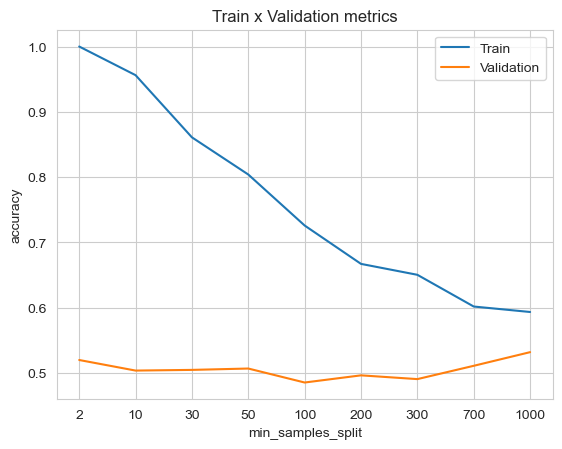

In [5]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

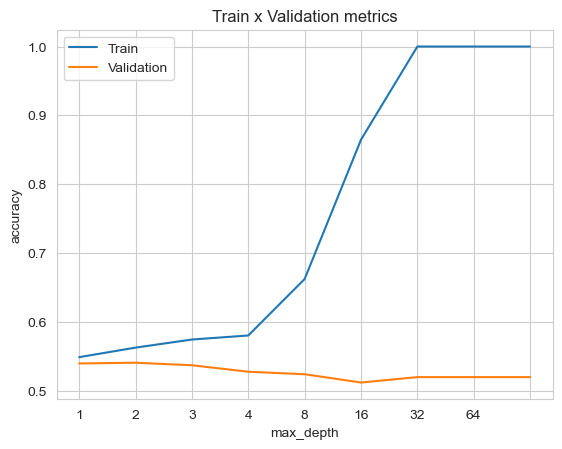

In [6]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth= max_depth,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [7]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 1000,
                                             max_depth = 1,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5470
Metrics validation:
	Accuracy score: 0.5259


In [39]:
dt_features = list(zip(features, decision_tree_model.feature_importances_))
sorted(dt_features, key=lambda x: x[1], reverse=True)

[('stoch_rsi_lag4', 1.0),
 ('roc_4w', 0.0),
 ('roc_6w', 0.0),
 ('roc_12w', 0.0),
 ('roc_26w', 0.0),
 ('roc_52w', 0.0),
 ('rsi', 0.0),
 ('ewma_vol', 0.0),
 ('skew', 0.0),
 ('kurtosis', 0.0),
 ('MACD_Line', 0.0),
 ('Signal_Line', 0.0),
 ('MACD_Histogram', 0.0),
 ('stoch_rsi', 0.0),
 ('ht_dcperiod', 0.0),
 ('ht_dcphase', 0.0),
 ('inphase', 0.0),
 ('sine', 0.0),
 ('ht_trendmode', 0.0),
 ('roc_4w_lag1', 0.0),
 ('roc_6w_lag1', 0.0),
 ('roc_12w_lag1', 0.0),
 ('roc_26w_lag1', 0.0),
 ('roc_52w_lag1', 0.0),
 ('rsi_lag1', 0.0),
 ('ewma_vol_lag1', 0.0),
 ('skew_lag1', 0.0),
 ('kurtosis_lag1', 0.0),
 ('MACD_Line_lag1', 0.0),
 ('Signal_Line_lag1', 0.0),
 ('MACD_Histogram_lag1', 0.0),
 ('stoch_rsi_lag1', 0.0),
 ('ht_dcperiod_lag1', 0.0),
 ('ht_dcphase_lag1', 0.0),
 ('inphase_lag1', 0.0),
 ('sine_lag1', 0.0),
 ('ht_trendmode_lag1', 0.0),
 ('roc_4w_lag2', 0.0),
 ('roc_6w_lag2', 0.0),
 ('roc_12w_lag2', 0.0),
 ('roc_26w_lag2', 0.0),
 ('roc_52w_lag2', 0.0),
 ('rsi_lag2', 0.0),
 ('ewma_vol_lag2', 0.0),
 ('

## Random Forest

In [8]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

### Min Samples Hyperparameter Analysis

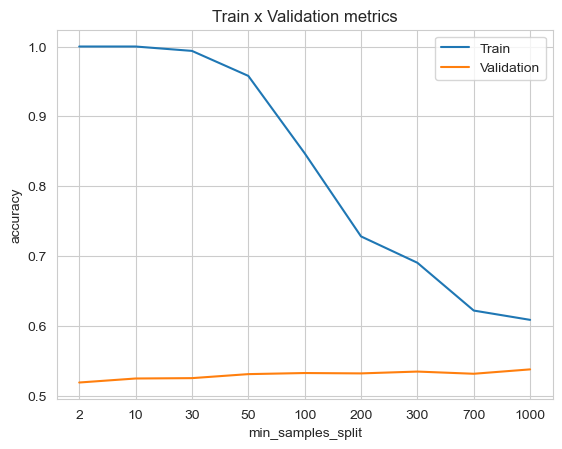

In [9]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### Max Depth Hyperparameter Analysis

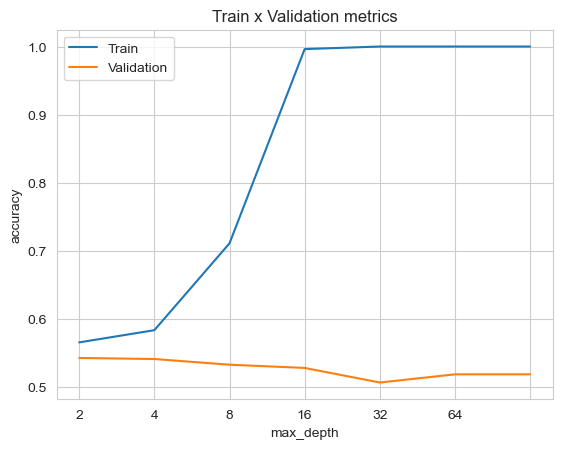

In [10]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth=max_depth,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

### N Estimators Hyperparameter Analysis

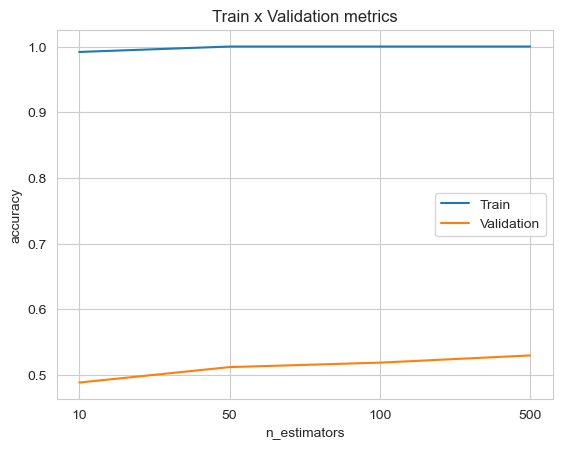

In [11]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train_fit,y_train_fit) 
    predictions_train = model.predict(X_train_fit) ## The predicted values for the train dataset
    predictions_val = model.predict(X_train_eval) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train_fit)
    accuracy_val = accuracy_score(predictions_val,y_train_eval)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [12]:
random_forest_model = RandomForestClassifier(n_estimators = 80,
                                             max_depth = 2, 
                                             min_samples_split = 700).fit(X_train,y_train)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5577
Metrics test:
	Accuracy score: 0.5271


In [38]:
rf_features = list(zip(features, random_forest_model.feature_importances_))
sorted(rf_features, key=lambda x: x[1], reverse=True)

[('MACD_Histogram', 0.08373750184446048),
 ('MACD_Line', 0.07912858805113734),
 ('MACD_Histogram_lag12', 0.06539434646481813),
 ('stoch_rsi_lag4', 0.05556669190424596),
 ('MACD_Line_lag1', 0.03751694757717157),
 ('ewma_vol', 0.03203430628236142),
 ('roc_12w', 0.031367650508814085),
 ('Signal_Line_lag6', 0.0302829869332427),
 ('roc_6w_lag12', 0.025470517471053285),
 ('roc_4w_lag12', 0.025233263487947282),
 ('MACD_Histogram_lag4', 0.02212860878900514),
 ('roc_52w_lag12', 0.020114593903018053),
 ('MACD_Histogram_lag2', 0.01982089446903231),
 ('rsi_lag6', 0.019144479498801922),
 ('inphase_lag6', 0.01882192359348376),
 ('MACD_Histogram_lag6', 0.01799920682179935),
 ('roc_52w_lag6', 0.017368620517744925),
 ('roc_4w_lag6', 0.016742065363447828),
 ('MACD_Line_lag4', 0.01593039050121501),
 ('rsi_lag4', 0.014527450045238316),
 ('roc_26w_lag1', 0.014480245872296082),
 ('roc_52w', 0.013712117898869714),
 ('ewma_vol_lag2', 0.0124531475424455),
 ('kurtosis_lag12', 0.012213042366312848),
 ('Signal_Li

## XGBoost

In [30]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [8, 32, None],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 500]
}

# Create the XGBoost model object
xgb_model = XGBClassifier(early_stopping_rounds=30, verbosity=1, random_state=RANDOM_STATE)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_fit, y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

[0]	validation_0-logloss:0.69140
[1]	validation_0-logloss:0.69308
[2]	validation_0-logloss:0.69344
[3]	validation_0-logloss:0.69528
[4]	validation_0-logloss:0.69614
[5]	validation_0-logloss:0.69649
[6]	validation_0-logloss:0.69641
[7]	validation_0-logloss:0.69670
[8]	validation_0-logloss:0.69766
[9]	validation_0-logloss:0.69782
[10]	validation_0-logloss:0.69687
[11]	validation_0-logloss:0.69695
[12]	validation_0-logloss:0.69745
[13]	validation_0-logloss:0.69820
[14]	validation_0-logloss:0.69942
[15]	validation_0-logloss:0.70167
[16]	validation_0-logloss:0.70304
[17]	validation_0-logloss:0.70266
[18]	validation_0-logloss:0.70273
[19]	validation_0-logloss:0.70250
[20]	validation_0-logloss:0.70241
[21]	validation_0-logloss:0.70354
[22]	validation_0-logloss:0.70427
[23]	validation_0-logloss:0.70526
[24]	validation_0-logloss:0.70579
[25]	validation_0-logloss:0.70677
[26]	validation_0-logloss:0.70682
[27]	validation_0-logloss:0.70690
[28]	validation_0-logloss:0.70714
[29]	validation_0-loglos

In [32]:
xgb_model = XGBClassifier(verbosity = 1, random_state = RANDOM_STATE, early_stopping_rounds=30, **grid_search.best_params_)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

[0]	validation_0-logloss:0.69349
[1]	validation_0-logloss:0.69772
[2]	validation_0-logloss:0.69979
[3]	validation_0-logloss:0.70504
[4]	validation_0-logloss:0.70828
[5]	validation_0-logloss:0.70991
[6]	validation_0-logloss:0.71014
[7]	validation_0-logloss:0.71222
[8]	validation_0-logloss:0.71331
[9]	validation_0-logloss:0.71440
[10]	validation_0-logloss:0.71635
[11]	validation_0-logloss:0.71950
[12]	validation_0-logloss:0.71933
[13]	validation_0-logloss:0.71990
[14]	validation_0-logloss:0.72103
[15]	validation_0-logloss:0.72228
[16]	validation_0-logloss:0.72642
[17]	validation_0-logloss:0.72742
[18]	validation_0-logloss:0.72860
[19]	validation_0-logloss:0.73007
[20]	validation_0-logloss:0.73206
[21]	validation_0-logloss:0.73335
[22]	validation_0-logloss:0.73394
[23]	validation_0-logloss:0.73470
[24]	validation_0-logloss:0.73600
[25]	validation_0-logloss:0.73762
[26]	validation_0-logloss:0.73885
[27]	validation_0-logloss:0.74013
[28]	validation_0-logloss:0.74124
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=30,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [33]:
xgb_model.best_iteration
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.5737
Metrics test:
	Accuracy score: 0.5263


In [34]:
# Save the models 
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(random_forest_model, 'random_forest_model.joblib')
joblib.dump(decision_tree_model, 'decision_tree.joblib')

['decision_tree.joblib']